In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

In [2]:
ocde_data = pd.read_csv('data/OCDE/DNK_OCDE.csv',
                        dtype={'Value': np.float64},
                       usecols = ['TIME', 'Value'])
ocde_data['TIME'] = pd.to_datetime(ocde_data['TIME'], infer_datetime_format=True)
ocde_data = ocde_data.set_index(['TIME'])

In [3]:
ocde_data.head()

,Value
TIME,
1987-01-01,10.5
1987-02-01,11.2
1987-03-01,10.4
1987-04-01,10.2
1987-05-01,10.0


In [4]:
# create a time series
s = pd.Series(ocde_data.unstack().values, index=ocde_data.index)

<AxesSubplot:xlabel='TIME'>

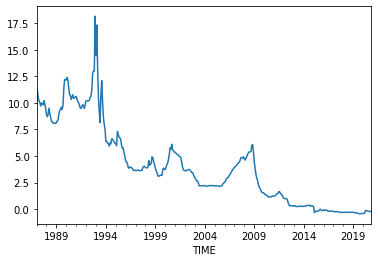

In [5]:
s.plot()

# Check stationarity

In [6]:
#Determining the rolling statistics
rolmean = ocde_data.rolling(window=12).mean()
rolstd = ocde_data.rolling(window=12).std()
print(rolmean, rolstd)

               Value
TIME                
1987-01-01       NaN
1987-02-01       NaN
1987-03-01       NaN
1987-04-01       NaN
1987-05-01       NaN
...              ...
2020-07-01 -0.325833
2020-08-01 -0.307500
2020-09-01 -0.289167
2020-10-01 -0.271667
2020-11-01 -0.256667

[407 rows x 1 columns]                Value
TIME                
1987-01-01       NaN
1987-02-01       NaN
1987-03-01       NaN
1987-04-01       NaN
1987-05-01       NaN
...              ...
2020-07-01  0.130903
2020-08-01  0.130393
2020-09-01  0.123837
2020-10-01  0.116762
2020-11-01  0.108656

[407 rows x 1 columns]


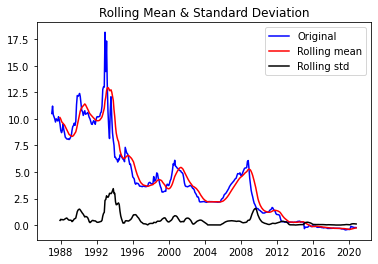

In [7]:
#plot rolling statistics
orig = plt.plot(ocde_data, color='blue', label = 'Original')
mean = plt.plot(rolmean, color='red', label='Rolling mean')
std = plt.plot(rolstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [8]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(ocde_data['Value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', 'Number of obervations used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -1.070721
p-value                         0.726606
#Lags used                     17.000000
Number of obervations used    389.000000
Critical Value (1%)            -3.447273
Critical Value (5%)            -2.868999
Critical Value (10%)           -2.570743
dtype: float64


Stationary? p-value small, test statistic < critical value

In [9]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries, color='blue', label = 'Original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:, 0], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', 'Number of obervations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

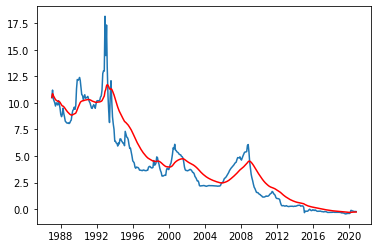

In [10]:
exponentialDecayWeightAverage = ocde_data.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(ocde_data)
plt.plot(exponentialDecayWeightAverage, color='red')

Results of Dickey-Fuller Test:
Test Statistic                 -4.091090
p-value                         0.001002
#Lags used                      6.000000
Number of obervations used    400.000000
Critical Value (1%)            -3.446804
Critical Value (5%)            -2.868793
Critical Value (10%)           -2.570634
dtype: float64


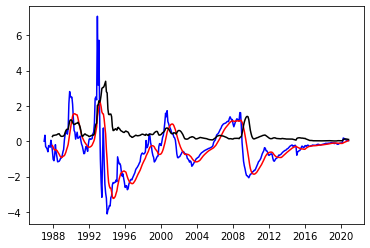

In [11]:
datasetMinusMovingExponentialDecayAverage = ocde_data - exponentialDecayWeightAverage
test_stationarity(datasetMinusMovingExponentialDecayAverage)

Results of Dickey-Fuller Test:
Test Statistic               -6.714940e+00
p-value                       3.601832e-09
#Lags used                    1.600000e+01
Number of obervations used    3.890000e+02
Critical Value (1%)          -3.447273e+00
Critical Value (5%)          -2.868999e+00
Critical Value (10%)         -2.570743e+00
dtype: float64


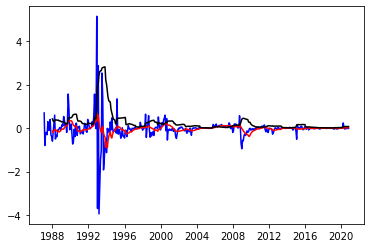

In [12]:
datasetDiffShifting = ocde_data - ocde_data.shift()
datasetDiffShifting.dropna(inplace=True)
test_stationarity(datasetDiffShifting)

# Prediction

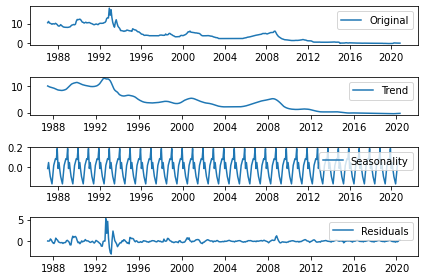

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ocde_data, period = 12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ocde_data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [14]:
decomposedData = residual
decomposedData.dropna(inplace = True)
#test_stationarity(decomposedData)

/home/ckennedy/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


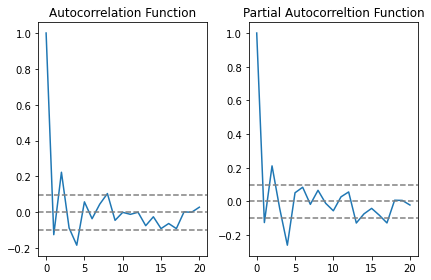

In [15]:
#ACF  and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetDiffShifting, nlags = 20)
lag_pacf = pacf(datasetDiffShifting, nlags=20, method='ols')

#Plot ACF (to dertermine p)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetDiffShifting)),linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetDiffShifting)),linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF (to determine q)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetDiffShifting)),linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetDiffShifting)),linestyle='--', color='gray')
plt.title('Partial Autocorreltion Function')
plt.tight_layout()

/home/ckennedy/.local/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ckennedy/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred f

Text(0.5, 1.0, 'RSS: 107.5981')

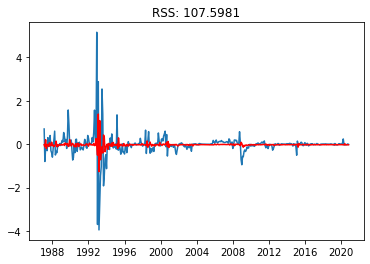

In [16]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(ocde_data, order=(3,1,0)) 
results_AR = model.fit(disp=-1)
plt.plot(datasetDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetDiffShifting['Value'])**2))

/home/ckennedy/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ckennedy/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 107.5981')

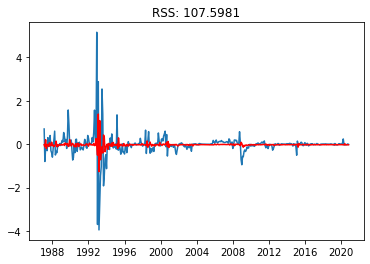

In [17]:
#MA MODEL
model = ARIMA(ocde_data, order=(0,1,3)) 
results_MA = model.fit(disp=-1)
plt.plot(datasetDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetDiffShifting['Value'])**2))

/home/ckennedy/.local/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ckennedy/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred f

Text(0.5, 1.0, 'RSS: 107.5981')

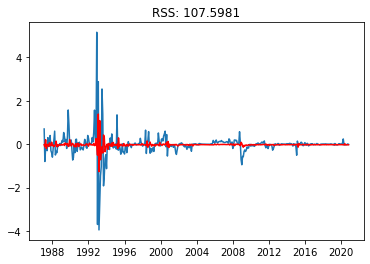

In [39]:
#ARIMA MODEL
model = ARIMA(ocde_data, order=(3,1,3)) 
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetDiffShifting['Value'])**2))

In [40]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

TIME
1987-02-01   -0.028153
1987-03-01   -0.136582
1987-04-01    0.184946
1987-05-01   -0.158487
1987-06-01   -0.101965
dtype: float64


In [41]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

TIME
1987-02-01   -0.028153
1987-03-01   -0.164735
1987-04-01    0.020211
1987-05-01   -0.138276
1987-06-01   -0.240240
dtype: float64


In [42]:
predictions_ARIMA = pd.Series(ocde_data['Value'], index=ocde_data.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA.head()

TIME
1987-01-01    10.500000
1987-02-01    11.171847
1987-03-01    10.235265
1987-04-01    10.220211
1987-05-01     9.861724
dtype: float64

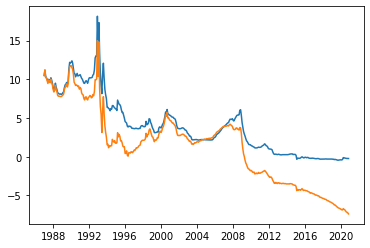

In [43]:
plt.plot(ocde_data) 
plt.plot(predictions_ARIMA)

In [44]:
ocde_data

,Value
TIME,
1987-01-01,10.50
1987-02-01,11.20
1987-03-01,10.40
1987-04-01,10.20
1987-05-01,10.00
...,...
2020-07-01,-0.19
2020-08-01,-0.21
2020-09-01,-0.23


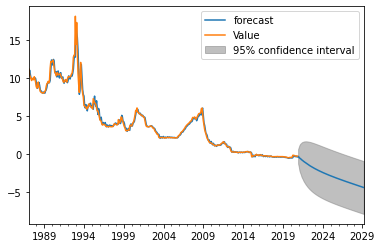

In [45]:

results_ARIMA.plot_predict(1,506)
x=results_ARIMA.forecast(steps = 40)